## Imports and installs
We will need the Ultralytics library to use [YOLOv5](https://docs.ultralytics.com/yolov5/) together with PyTorch.

In [4]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.5/756.5 kB 28.2 MB/s eta 0:00:00


In [5]:
# System libraries
import os
import random
import yaml
from PIL import Image
from tqdm import tqdm

# Data analytics and visualisations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchinfo import summary

## Data Exploration
We will use the WIDER FACE dataset. Let's look at some folders and images.

In [6]:
root = '/kaggle/input/wider-face-a-face-detection-benchmark/'
train_img_folder = f"{root}wider_train/WIDER_train/images/"
val_img_folder = f"{root}wider_val/WIDER_val/images/"
annotations_folder = f"{root}wider_face_split/wider_face_split/"

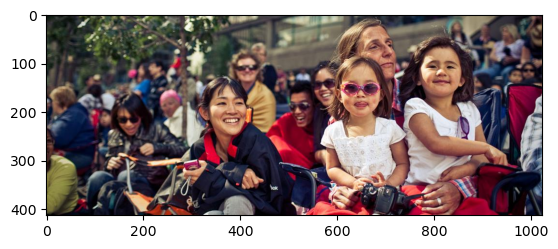

In [7]:
img = Image.open(f"{train_img_folder}0--Parade/0_Parade_Parade_0_3.jpg")
plt.imshow(img)

In [8]:
os.listdir(annotations_folder)

['wider_face_train_bbx_gt.txt',
 'wider_face_val_bbx_gt.txt',
 'wider_face_test.mat',
 'readme.txt',
 'wider_face_val.mat',
 'wider_face_test_filelist.txt',
 'wider_face_train.mat']

The bounding box text files should be in the format:

> File name
>
> Number of bounding box
>
> x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose

Therefore, a custom loader will be needed. Let's create a function to extract all important annotations from each of the files.

In [9]:
train_bbx_path = f"{annotations_folder}wider_face_train_bbx_gt.txt"
val_bbx_path = f"{annotations_folder}wider_face_val_bbx_gt.txt"

In [10]:
def load_bbx(bbx_path):
    with open(bbx_path, mode='r') as file:
        lines = file.readlines()
        
    annotations = {}
    i = 0
    while i < len(lines):
        file_name = lines[i].strip()
        i += 1
        num_boxes = int(lines[i].strip())
        i += 1
        boxes = []
        for _ in range(num_boxes):
            box_info = lines[i].strip().split()
            box = {
                'x': int(box_info[0]),
                'y': int(box_info[1]),
                'w': int(box_info[2]),
                'h': int(box_info[3]),
            }
            boxes.append(box)
            i += 1
        annotations[file_name] = boxes

    return annotations

The outputs will be saved to custom lists of dictionaries and we'll also add the keys to their separate lists.

In [11]:
train_annotations = load_bbx(train_bbx_path)
val_annotations = load_bbx(val_bbx_path)

train_keys = []
val_keys = []
for key in train_annotations.keys():
    train_keys.append(key)
for key in val_annotations.keys():
    val_keys.append(key)

## Dataset
The YOLOv5 algorithm expects the annotations to be in a text file with a center instead of a top-left corner defined, therefore we need to convert the annotations to a dataframe, which will be later converted to a text file.

In [12]:
def annotation_to_df(annotation, img_shape):
    cs, xs, ys, ws, hs = [], [], [], [], []
    
    h, w, _ = img_shape
    for box in annotation:
        cs.append(0)
        xs.append((box["x"] + box["w"] / 2.0) / w)
        ys.append((box["y"] + box["h"] / 2.0) / h)
        ws.append(box["w"] / w)
        hs.append(box["h"] / h)
        
    return pd.DataFrame({0:cs, 1:xs, 2:ys, 3:ws, 4:hs})

We will need a different plotting method for this kind of data.

In [13]:
def plot_boxes(img, df):
    h, w, _ = img.shape
    
    fig, ax = plt.subplots()
    for index, row in df.iterrows():
        patch = Rectangle(
            ((row[1] - row[3] / 2.0) * w, (row[2] - row[4] / 2.0) * h),
            row[3] * w,
            row[4] * h,
            edgecolor = 'red',
            fill=False,
        )
        ax.add_patch(patch)
    
    plt.imshow(img)

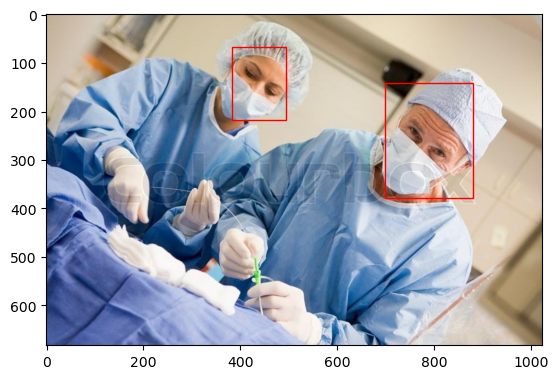

In [14]:
# Sample plot
key = train_keys[random.randint(0, len(train_keys) - 1)]
img = np.array(Image.open(f"{train_img_folder}{key}"))
df = annotation_to_df(train_annotations[key], img.shape)
plot_boxes(img, df)

The data is expected to be in this structure:
```
datasets
│
└── facest
    │
    ├── images
    │   ├── train
    │   └── val
    │
    └── labels
        ├── train
        └── val
```
We will copy the images from the dataset into the correct structure and add text files with the annotations. Running the cells bellow might take a while.

In [15]:
def add_dataset(keys, annotations, img_folder, root, split):
    if not os.path.exists(root):
        os.makedirs(root)
    if not os.path.exists(f"{root}images/{split}"):
        os.makedirs(f"{root}images/{split}")
        os.makedirs(f"{root}labels/{split}")
    
    for i, key in enumerate(keys):
        img = np.array(Image.open(f"{img_folder}{key}"))
        Image.fromarray(img).save(f"{root}images/{split}/im{i}.jpg")
        df = annotation_to_df(annotations[key], img.shape)
        df.to_csv(f"{root}labels/{split}/im{i}.txt", header=False, index=False, sep='\t')

In [16]:
len(train_keys), len(val_keys)

(12880, 3226)

In [17]:
add_dataset(train_keys, train_annotations, train_img_folder, "/kaggle/working/datasets/faceset/", "train")

In [18]:
add_dataset(val_keys, val_annotations, val_img_folder, "/kaggle/working/datasets/faceset/", "val")

Since we will use YOLOv5 as the base model for fine-tuning, we will clone the library from GitHub and install the required packages.

In [19]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r "requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16582, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 16582 (delta 30), reused 39 (delta 18), pack-reused 16522
Receiving objects: 100% (16582/16582), 15.13 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (11387/11387), done.
/kaggle/working/yolov5
/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
Note: you may need to restart the kernel to use updated packages.


We will need to create a file that specifies the locations of each of these folders, as well as each of the classes (there is only a single class).

In [20]:
dict_file = {"path":"../datasets/faceset",
             "train":"images/train",
             "val":"images/val",
             "nc":0,
             "names": ["face"]}

with open("/kaggle/working/yolov5/data/dataset.yaml", 'w') as file:
    documents = yaml.dump(dict_file, file)

## Transfer Learning
Let's train the model for 12 epochs using a batch size of 32 (larger might not fit into the GPU memory). The image size is set to 640x640, training using a larger image size might have better performance at the cost of waiting longer for the model to train.

In [24]:
!python train.py --img 640 --epochs 12 --batch-size 32 --data dataset.yaml --weights yolov5s.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=12, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndj

After we are done training, we can load our custom model and test it on some sample data.

In [43]:
!cp -r /kaggle/input/weight/best.pt /kaggle/working/yolov5/runs/train/exp/weights

In [46]:
custom_yolov5 = torch.hub.load('/kaggle/working/yolov5', 'custom', path='runs/train/exp/weights/best.pt', force_reload=True, source='local')

YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [47]:
# Changing settings to prevent finding the faces multiple times
custom_yolov5.conf = 0.5
custom_yolov5.iou = 0.3

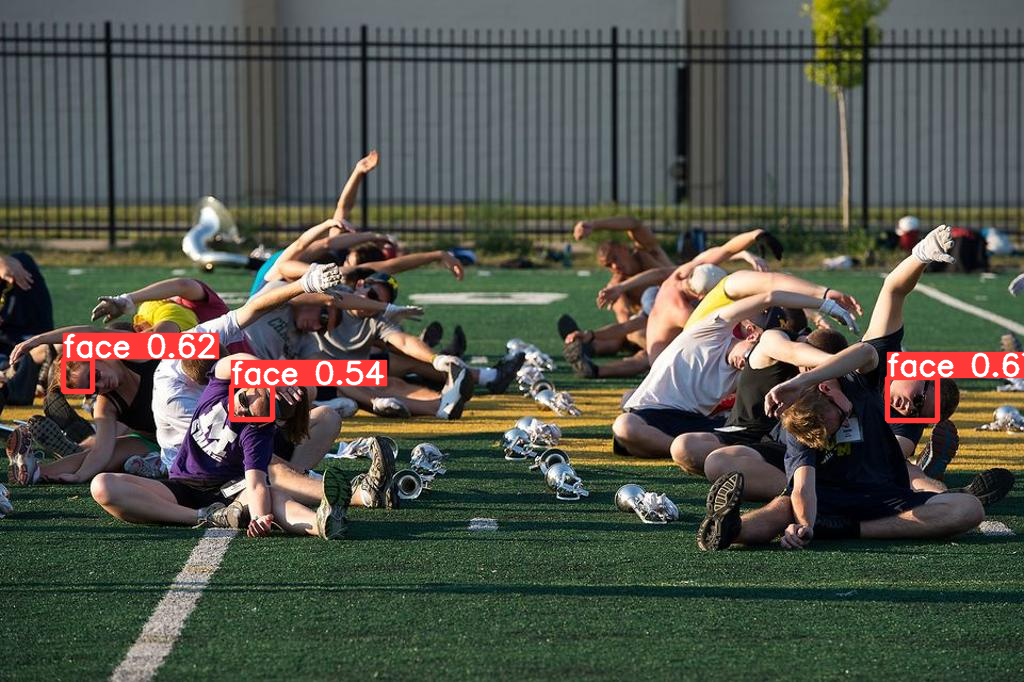

In [48]:
output = custom_yolov5(f"{train_img_folder}{train_keys[3]}")
output.show()

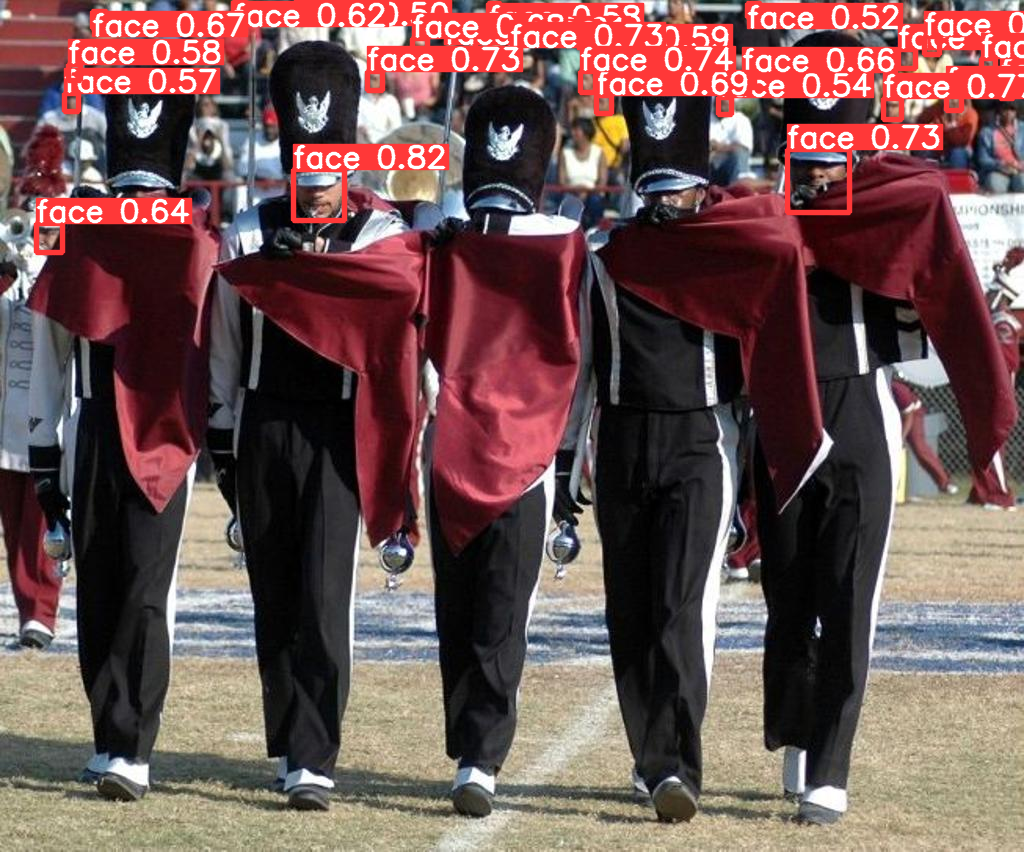

In [49]:
output = custom_yolov5(f"{train_img_folder}{train_keys[4]}")
output.show()

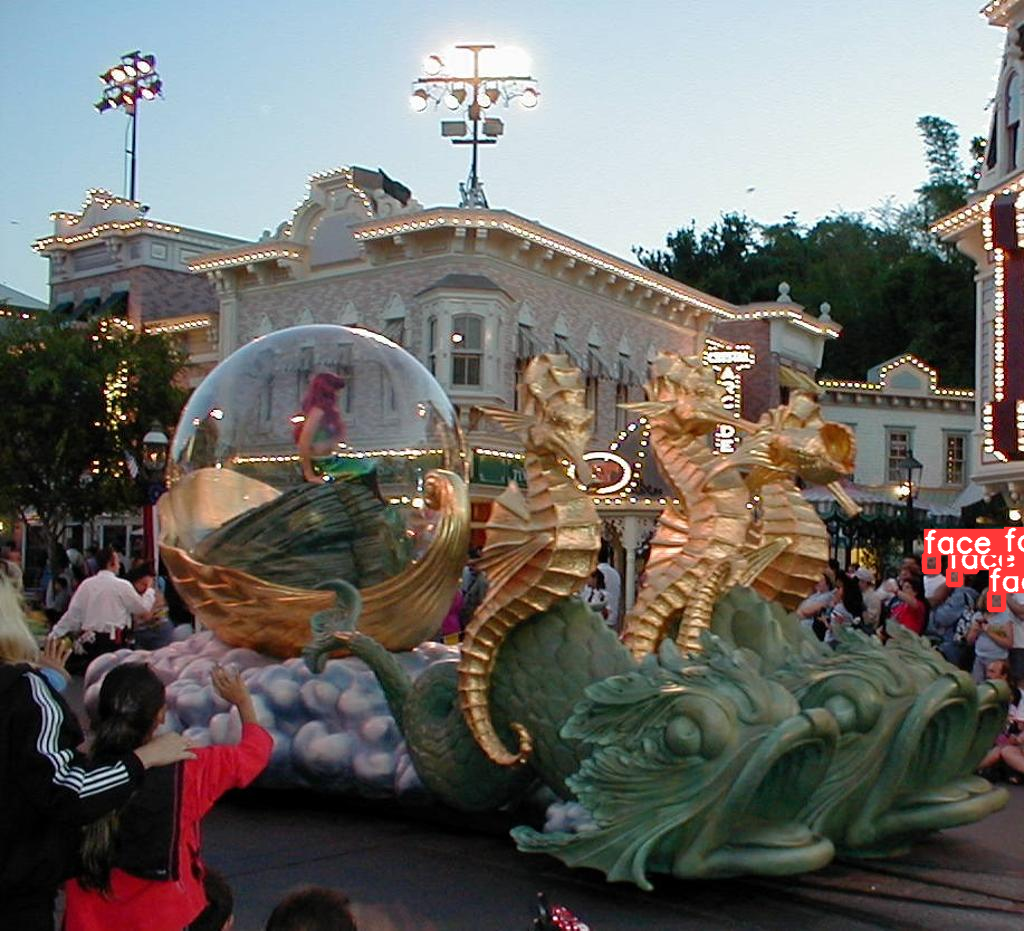

In [50]:
output = custom_yolov5(f"{train_img_folder}{train_keys[5]}")
output.show()